In [1]:
#%matplotlib qt

## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [2]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

In [3]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

In [4]:
def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    radii = [0, 15, 20, 22, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time, data)
        
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
#PlotRadiiStrain('Data/HeadOn/JoinedLev1/')
PlotRadiiStrain('Data/HeadOn_Harmonic/JoinedLev1/')

OSError: Unable to open file (unable to open file: name = 'Data/HeadOn_Harmonic/JoinedLev1/GW2/rPsi4_FiniteRadii_CodeUnits.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<Figure size 1008x576 with 0 Axes>

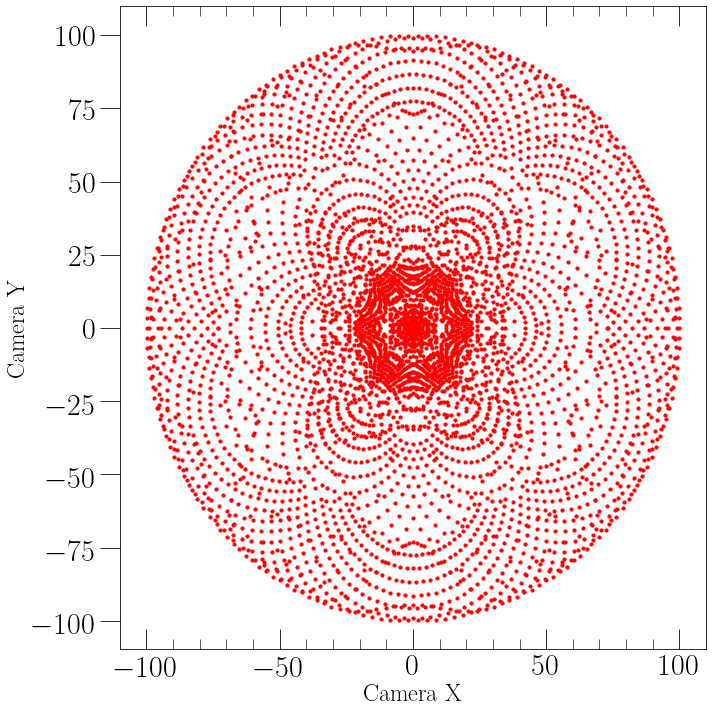

In [132]:
## Plot the vanilla SpEC lensing run results

def PlotRefinementMethodResult(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""
    
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_positions = data[:,1]
    y_positions = data[:,2]
    z_positions = data[:,3]
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(y_positions, z_positions, color='red', s=10)
    #plt.xlim(-5.0, 5.0)
    #plt.ylim(-5.0, 5.0)

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.savefig('Camera.pdf')
    plt.show()
    
PlotRefinementMethodResult('Data/Kerr')

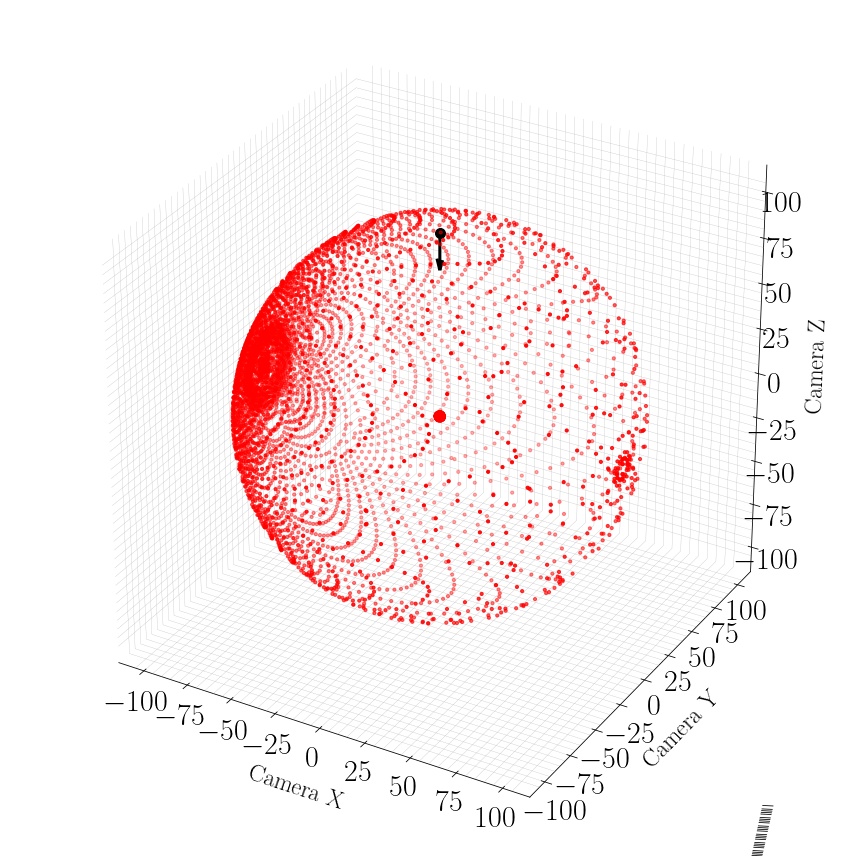

In [128]:
## Plot the vanilla SpEC lensing run results

def Plot3DFinalPositions(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""

    plt.rcParams['grid.linewidth'] = 0.25
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_pos = data[:,1]
    y_pos = data[:,2]
    z_pos = data[:,3]
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.scatter(x_pos, y_pos, z_pos, color='red', s=10)
    ax.scatter([0.0], [0.0], [100.0], color='black', s = 100)
    ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='black')
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    plt.tight_layout()
    plt.savefig('Positions.pdf')
    plt.show()
    
Plot3DFinalPositions('Data/Kerr')


In [4]:
## Helper functions for reading geodesic positions over time from NodeX.h5 files

def read_geodesic_data(p):
    """ Read in an array of times and positions for all geodesics at once"""
        
    file = p + '/Node0.h5'
    f = h5py.File(file, 'r')
    ## grab the .dat files
    keys = [k for k in f.keys() if 'dat' in k]
    ## Array of times from the .dat files
    times = [float(k.split('.dat')[0]) for k in keys]
    ## sort keys according to times
    times, keys = zip(*sorted(zip(times, keys)))
    times = times[::-1]
    keys = keys[::-1]
    ## grab the number of geodesics
    N_geodesics = len(f[keys[0]][:,0])
    print("Total geodesics: ", N_geodesics, "Time steps: ", len(times))
    ## Minimum index
    m = int(f[keys[0]][:,0][0])
    print("Minimum index of this refinement iteration: ", m)
    
    X = [ [] for _ in range(N_geodesics)]
    Y = [ [] for _ in range(N_geodesics)]
    Z = [ [] for _ in range(N_geodesics)]
    T = [ [] for _ in range(N_geodesics)]
    
    for k, t in zip(keys, times):
        data = f[k]
        ## indices and positions for all geodesics at this time
        indices = data[:,0]
        x = data[:,5]
        y = data[:,6]
        z = data[:,7]
        ## fill in the array for each index
        for i, j in zip(indices.astype(int), range(len(indices))):
            X[i-1-m] = np.append(X[i-1-m], x[j])
            Y[i-1-m] = np.append(Y[i-1-m], y[j])
            Z[i-1-m] = np.append(Z[i-1-m], z[j])
            T[i-1-m] = np.append(T[i-1-m], t)
            
    return T, X, Y, Z

def grab_geodesic_data(a, T, X, Y, Z):

    x = X[a]
    y = Y[a]
    z = Z[a]
    t = T[a]
    return t, x, y, z
    


In [ ]:
## Plot 3d geodesic trajectories from NodeX.h5 files

def PlotTrajectories(p):
    
    t_start = time.perf_counter()
        
    T, X, Y, Z = read_geodesic_data(p)
     
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    
    #ax.scatter(x[0:1000], y[0:1000], z[0:1000])
    for n in np.arange(0, len(X), 1000):
        t, x, y, z = grab_geodesic_data(n, T, X, Y, Z)
        ax.plot(x, y, z, color='black', lw=0.2)

       
    #ax.scatter([0.0], [0.0], [100.0], color='blue', s = 200)
    #ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='blue')
    
    ax.scatter([0.0], [0.0], [0.0], color='red', s = 100, symbol='+')
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    #ax.set_xlim(-10, 10)
    #ax.set_ylim(-10, 10)
    #ax.set_zlim(-10, 10)
    
    plt.tight_layout()
    plt.savefig('Histories.pdf')
    plt.show()
    
    t_end = time.perf_counter()
    print(t_start - t_end)


#PlotTrajectories('Data/Kerr')
PlotTrajectories('Data/HeadOn_0')

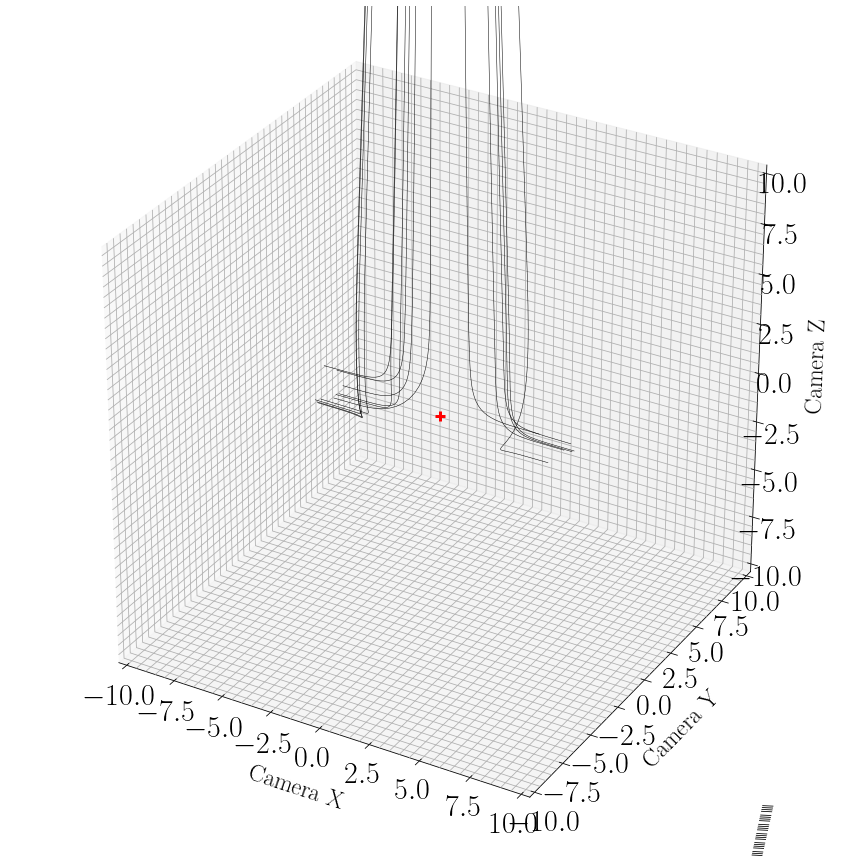

-2.780966117999924


In [47]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable

def ReadGetTrajectoriesFromH5(p, n):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + '/Trajectories/' + str(n) + '.dat'
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,5,6,7]),unpack=True)
    return t, x, y, z

def ReadRedshiftGetTrajectoriesFromH5(p, n):
    """ Read in the post-processed trajectory for the nth geodesic, 
        also output the redshift """
    f = p + '/Trajectories/' + str(n) + '.dat'
    t, p0, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,5,6,7]),unpack=True)
    return t, p0, x, y, z

def PlotGetTrajectoriesFromH5(p, figname):
    
    t_start = time.perf_counter()
     
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    for n in np.arange(0, 1000, 1):
        t, p0, x, y, z = ReadRedshiftGetTrajectoriesFromH5(p, n)
        r2min = min(x**2 + y**2 + z**2)
        if (r2min < 50 and max(p0) > 2):
            ax.plot(x, y, z, lw=0.5, color='black')
        #print(max(p0),)
        #if(max(p0) > 1):

    #ax.scatter([0.0], [0.0], [100.0], color='blue', s = 200)
    #ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='blue')
    
    ax.scatter([0.0], [0.0], [0.0], color='red', s =100, marker='+')
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(-10, 10)
    
    ## Plot sphere
    #R = 100
    #u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    #x = R*np.cos(u)*np.sin(v)
    #y = R*np.sin(u)*np.sin(v)
    #z = R*np.cos(v)
    #ax.plot_wireframe(x, y, z, color="b", linewidth=0.1)
    
    plt.tight_layout()
    plt.savefig('Histories_' + figname + '.pdf')
    plt.show()
    
    t_end = time.perf_counter()
    print(t_start - t_end)


PlotGetTrajectoriesFromH5('Data/HeadOn_50/', 'HeadOn_50')

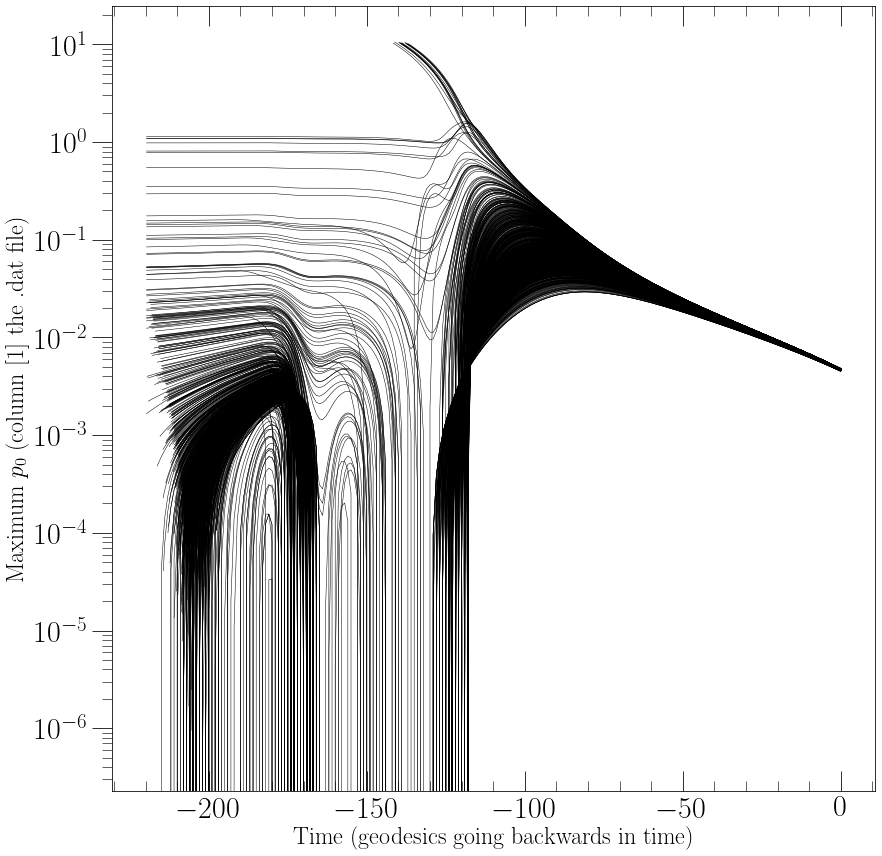

In [39]:
def PlotRedshiftsGetTrajectoriesFromH5Time(p, figname):
     
    fig = plt.figure(figsize=(12,12))
    #ax = fig.add_subplot(111, projection='3d')
    
    redshifts = []
    rmins = []
    for n in np.arange(0, 1000, 1):
        t, p0, x, y, z = ReadRedshiftGetTrajectoriesFromH5(p, n)
        r2min = min(x**2 + y**2 + z**2)
        t = t - 269.7
        plt.plot(t, p0, color='black', lw=0.5)
    
    plt.scatter(rmins, redshifts)
    plt.xlabel('Time (geodesics going backwards in time)')
    plt.ylabel('Maximum $p_0$ (column [1] the .dat file)')
    plt.tight_layout()
    plt.savefig('Redshifts_' + figname + '.pdf')
    plt.yscale('log')
    plt.show()
    
    
PlotRedshiftsGetTrajectoriesFromH5Time('Data/HeadOn_50/', 'HeadOn_50')

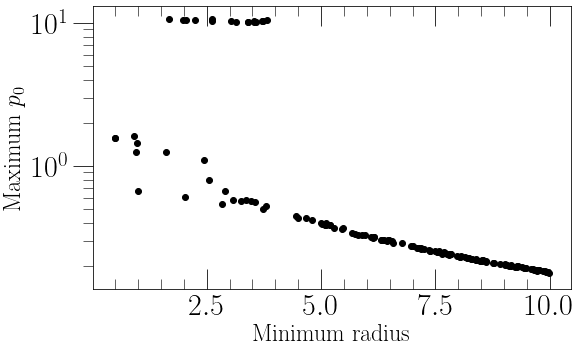

In [46]:
def PlotRedshiftsGetTrajectoriesFromH5(p, figname):
     
    fig = plt.figure(figsize=(8,5))
    #ax = fig.add_subplot(111, projection='3d')
    
    redshifts = []
    rmins = []
    for n in np.arange(0, 1000, 1):
        t, p0, x, y, z = ReadRedshiftGetTrajectoriesFromH5(p, n)
        r2min = min(x**2 + y**2 + z**2)
        if (r2min < 100):
            redshifts.append(max(p0))
            rmins.append(sqrt(r2min))
        #t = t - 269.7
        #plt.plot(t, p0, color='black', lw=0.5)
    
    plt.scatter(rmins, redshifts, color='black')
    plt.xlabel('Minimum radius')
    plt.ylabel('Maximum $p_0$')
    plt.tight_layout()
    plt.savefig('Redshifts_' + figname + '.pdf')
    plt.yscale('log')
    plt.show()
    
    
PlotRedshiftsGetTrajectoriesFromH5('Data/HeadOn_50/', 'HeadOn_50')